In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

# Datenvorverarbeitung

In [3]:
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_ALL_D4_t_21_I_F_PKL.pkl')
data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,100,6000,5000,449.80
1,0.0000,-0.00192,100,6000,5000,479.76
2,0.0000,-0.00184,100,6000,5000,506.60
3,0.0000,-0.00176,100,6000,5000,530.80
4,0.0000,-0.00168,100,6000,5000,552.15
...,...,...,...,...,...,...
351283,0.0024,0.00168,500,9000,5000,1365.50
351284,0.0024,0.00176,500,9000,5000,1247.20
351285,0.0024,0.00184,500,9000,5000,1114.10
351286,0.0024,0.00192,500,9000,5000,983.97


In [12]:
# Mit der Bedingung wird die Simulationsdatei I7000 F6000 ausgewählt.
bedingung = (data['Kraft'] == 6000) & (data['Strom'] == 7000)
#df_test setzt sich aus der Simulation I7000 F6000 mit 21 Zeitschritten zwischen 100ms und 500 ms zusammen
df_test = data[bedingung].copy()
print(df_test)
data_all = data.drop(df_test.index) # Testdaten aus den Trainingsdaten droppen
print(data_all[(data_all['Kraft'] == 6000) & (data_all['Strom'] == 7000)]) # Kontrolle
#print(data_all[(data_all['Kraft'] == 6000) & (data_all['Strom'] == 7000)])


# df_test_500 setzt sich alleine aus dem Zeitpunkt t = 500ms für Simulation I7000 F6000 zusammen
df_test_500 = df_test[(df_test['Zeitpunkt'] == 500)] #

# Data shufflen
data_all = data_all.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen
df_reset = data_all.reset_index(drop=True)
df_reset

#Zuweisung der Trainingsdaten
y = df_reset["Temperatur"]
X = df_reset.drop("Temperatur", axis=1)

# Zuweisung der Testdaten
y_2 = df_test["Temperatur"]
X_2 = df_test.drop("Temperatur", axis=1)
X_2 = X_2.reset_index(drop=True)

        X-Koordinate  Y-Koordinate  Zeitpunkt  Strom  Kraft  Temperatur
131733        0.0000      -0.00200        100   7000   6000      478.13
131734        0.0000      -0.00192        100   7000   6000      511.16
131735        0.0000      -0.00184        100   7000   6000      541.43
131736        0.0000      -0.00176        100   7000   6000      569.14
131737        0.0000      -0.00168        100   7000   6000      594.14
...              ...           ...        ...    ...    ...         ...
175639        0.0024       0.00168        500   7000   6000      942.96
175640        0.0024       0.00176        500   7000   6000      865.10
175641        0.0024       0.00184        500   7000   6000      786.99
175642        0.0024       0.00192        500   7000   6000      708.11
175643        0.0024       0.00200        500   7000   6000      690.48

[22491 rows x 6 columns]
Empty DataFrame
Columns: [X-Koordinate, Y-Koordinate, Zeitpunkt, Strom, Kraft, Temperatur]
Index: []
Empty Dat

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft
0,0.00084,0.00040,260,7000,9000
1,0.00084,0.00152,460,8000,7000
2,0.00012,-0.00104,320,8000,7000
3,0.00132,0.00120,400,8000,7000
4,0.00132,0.00064,280,7000,9000
...,...,...,...,...,...
157432,0.00228,0.00032,220,8000,7000
157433,0.00204,-0.00112,340,8000,6000
157434,0.00036,0.00168,460,8000,7000
157435,0.00024,0.00104,320,9000,5000


In [13]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X)
X_test_scaled = scaler_features.transform(X_2)
# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()
# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_2.values.reshape(-1, 1))

In [17]:
X_test_scaled

array([[0.        , 0.        , 0.        , 0.33333333, 0.25      ],
       [0.        , 0.02      , 0.        , 0.33333333, 0.25      ],
       [0.        , 0.04      , 0.        , 0.33333333, 0.25      ],
       ...,
       [1.        , 0.96      , 1.        , 0.33333333, 0.25      ],
       [1.        , 0.98      , 1.        , 0.33333333, 0.25      ],
       [1.        , 1.        , 1.        , 0.33333333, 0.25      ]])

In [15]:
y_train_scaled

array([[0.20797414],
       [0.41215193],
       [0.59782138],
       ...,
       [0.32599012],
       [0.76202929],
       [0.49529289]])

In [8]:
# Netzwerkarchitektur
model = Sequential([

    Dense(280, activation='relu', input_shape=(5,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(232, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(152, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(40, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(88, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(280, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 200 
epochs = 2000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

model.save('D4_t_21_I_F_1.h5')

Epoch 1/2000
630/630 [==============================] - 3s 3ms/step - loss: 0.0257 - mae: 0.0471 - val_loss: 0.0206 - val_mae: 0.0291
Epoch 2/2000
630/630 [==============================] - 2s 3ms/step - loss: 0.0191 - mae: 0.0201 - val_loss: 0.0180 - val_mae: 0.0159
Epoch 3/2000
630/630 [==============================] - 2s 3ms/step - loss: 0.0173 - mae: 0.0144 - val_loss: 0.0166 - val_mae: 0.0118
Epoch 4/2000
630/630 [==============================] - 2s 3ms/step - loss: 0.0161 - mae: 0.0116 - val_loss: 0.0155 - val_mae: 0.0103
Epoch 5/2000
630/630 [==============================] - 2s 3ms/step - loss: 0.0150 - mae: 0.0104 - val_loss: 0.0145 - val_mae: 0.0097
Epoch 6/2000
630/630 [==============================] - 2s 3ms/step - loss: 0.0140 - mae: 0.0096 - val_loss: 0.0136 - val_mae: 0.0107
Epoch 7/2000
630/630 [==============================] - 2s 3ms/step - loss: 0.0132 - mae: 0.0095 - val_loss: 0.0127 - val_mae: 0.0081
Epoch 8/2000
630/630 [==============================] - 2s 3ms

C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
#Kreuzvalidierung auf den Trainingsdaten
# Initialisiere Listen, um Ergebnisse zu speichern
val_loss_results = []
val_mae_results = []

# Funktion, um das Modell zu erstellen
def create_model():
    model = Sequential([
            Dense(280, activation='relu', input_shape=(5,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(232, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(152, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(40, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(88, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(280, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(1 , activation = 'linear')

    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# K-Fold Cross-Validation Konfiguration
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Leistungsüberwachung
fold_no = 1
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    print(f'Training für Fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, batch_size=200, epochs=1000, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Speichere die Ergebnisse des aktuellen Folds
    val_loss_results.append(min(history.history['val_loss']))
    val_mae_results.append(min(history.history['val_mae']))

    fold_no += 1

# Berechne den Durchschnitt über alle Folds
average_val_loss = np.mean(val_loss_results)
average_val_mae = np.mean(val_mae_results)

# Umwandeln der Listen in Pandas DataFrames
val_loss_df = pd.DataFrame(val_loss_results, columns=['Validation Loss'])
val_mae_df = pd.DataFrame(val_mae_results, columns=['Validation MAE'])

# Speichern der DataFrames in CSV-Dateien
val_loss_df.to_csv('val_loss_results_D4_t_21_I_F_1.csv', index=False)
val_mae_df.to_csv('val_mae_results_D4_t_21_I_F_1.csv', index=False)

# Gib die durchschnittlichen Ergebnisse aus
print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
print(f'Durchschnittlicher Validation MAE: {average_val_mae}')


Training für Fold 1...
Epoch 1/1000
630/630 [==============================] - 5s 5ms/step - loss: 0.0350 - mae: 0.0691 - val_loss: 0.0230 - val_mae: 0.0373
Epoch 2/1000
630/630 [==============================] - 3s 5ms/step - loss: 0.0213 - mae: 0.0297 - val_loss: 0.0201 - val_mae: 0.0247
Epoch 3/1000
630/630 [==============================] - 3s 5ms/step - loss: 0.0193 - mae: 0.0207 - val_loss: 0.0186 - val_mae: 0.0177
Epoch 4/1000
630/630 [==============================] - 3s 5ms/step - loss: 0.0182 - mae: 0.0159 - val_loss: 0.0177 - val_mae: 0.0141
Epoch 5/1000
630/630 [==============================] - 3s 4ms/step - loss: 0.0174 - mae: 0.0135 - val_loss: 0.0170 - val_mae: 0.0120
Epoch 6/1000
630/630 [==============================] - 3s 5ms/step - loss: 0.0167 - mae: 0.0119 - val_loss: 0.0163 - val_mae: 0.0114
Epoch 7/1000
630/630 [==============================] - 3s 5ms/step - loss: 0.0160 - mae: 0.0107 - val_loss: 0.0157 - val_mae: 0.0099
Epoch 8/1000
630/630 [=================

In [20]:
#Modellevaluierung
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

703/703 - 1s - loss: 3.9304e-04 - mae: 0.0113 - 781ms/epoch - 1ms/step


[0.0003930425154976547, 0.01132908370345831]

In [21]:
#Berechnung des MAE und MAPE
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Rücktransformation der skalierten Werte 
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")
errors = np.abs((original_actual_values - original_predicted_values) / original_actual_values)
mape = np.mean(errors) * 100
print(mape)

 Bsp. Predicted: [465.14783] Actual: [452.59] 
Durchschnittliche Abweichung (MAE): [25.12698166]
2.1801640749309192


In [18]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list2], 'Vorhergesagt': [val[0] for val in list1]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]
df_result['Zeitpunkt'] = X_test_scaled[:, 2]
df_result['Strom'] = X_test_scaled[:, 3]
df_result['Kraft'] = X_test_scaled[:, 4]

df_result['Differenz'] = abs(df_result['Echt'] - df_result['Vorhergesagt'])
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] < 20).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df


ValueError: Length of values (22491) does not match length of index (1071)

In [22]:
#Berechnung der Auswertungsgröße R^2

def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99989271]


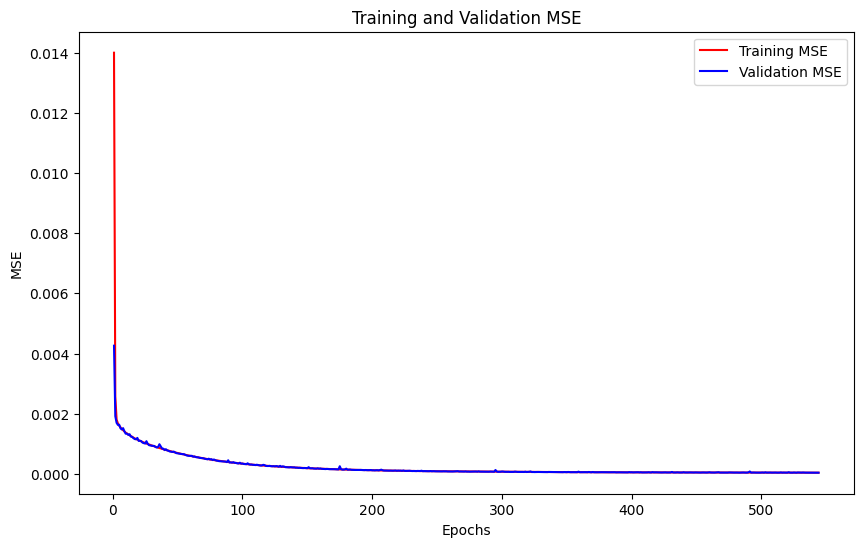

In [25]:
mse = history.history['loss']
val_mse = history.history['val_loss']

epochs = range(1, len(mse) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

# GridSearch

In [12]:
def build_model(learning_rate=0.00001, activation='relu', regularization=0.00001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(280, activation=activation, input_shape=(5,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(232, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(152, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(40, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(88, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(8, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(280, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=3)


model = KerasRegressor(model=build_model, verbose=2, callbacks=[early_stopping])

# Anpassung der Parameter im param_grid
param_grid = {
    'model__learning_rate': [0.00001],
    'model__regularization': [0.00001],
    'fit__batch_size': [16, 32, 64, 100, 200],
    'fit__epochs': [100],
    'model__dropout_rate' : [0.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# Hinweis: Sicherstellen, dass Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# Beste Parameter und Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit:", grid_search.best_score_)

with open("Gridsearch_D4_t_21_I_F_1.txt", "w") as f:
    f.write(f"Beste Parameter: {grid_search.best_params_}\n")
    f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001B625802E50>>
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Funktion zum Erstellen des Modells
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(5,), activation='relu'))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Durchführung der Random Search dreimal
for run in range(1, 4):
    # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
    directory = 'random_search'
    project_name = f'random_search_D4_t_21_I_F_{run}'

    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=100,
        executions_per_trial=1,
       directory=directory,
        project_name=project_name
    )

    # Durchführung des Random Search
    tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=200, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    # Abrufen und Speichern des besten Modells
    best_model = tuner.get_best_models(num_models=1)[0]
    model_path = os.path.join(directory, project_name, 'best_model.h5') 
    best_model.save(model_path)


    # Optional: Abrufen und Ausgeben der besten Hyperparameter
    best_hyperparameters = tuner.get_best_hyperparameters()[0]

    # Konvertieren der Hyperparameter in ein DataFrame
    df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
    # Speichern des DataFrame als CSV
    df_hyperparameters.to_csv(f'random_search_D4_t_21_I_F_{run}.csv', index=False)

    print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")
